# This notebook serves as a demonstration of how to perform vector search using text input, specifically in the context of a Coles shopping list scenario.

# Packages and credential

In [6]:
import openai
import os
from openai import cli
import pandas as pd
import urllib.request
import json 
import urllib.request
from PIL import Image
import matplotlib.pyplot as plt
import requests
import time
import os
import matplotlib.image as mpimg
import io
import azure.ai.vision as visionsdk
import base64
import concurrent.futures
from azure.storage.blob import BlobServiceClient, ContentSettings
import ast
import numpy as np
import math

# Load data from previous step 'OpenAI_coles_creating_data.ipynb'

In [4]:
df = pd.read_csv('Coles_products.csv', index_col=[0])

In [5]:
df

,product_name,product_id,price,prompt,dalle_url,final_url,vector
0,milk,1,3.49,"A carton of fresh, retail-ready milk",https://dalleproduse.blob.core.windows.net/pri...,https://retailcontosoclothing.blob.core.window...,"[-0.79296875, 0.91845703, 1.2021484, 0.6264648..."
1,butter,2,4.99,A commercially packaged block of butter,https://dalleproduse.blob.core.windows.net/pri...,https://retailcontosoclothing.blob.core.window...,"[-1.3417969, -2.2695312, -0.0025482178, -0.673..."
2,meat,3,8.99,"A neatly packed, retail-ready piece of meat",https://dalleproduse.blob.core.windows.net/pri...,https://retailcontosoclothing.blob.core.window...,"[-0.66308594, 1.671875, -3.1621094, -2.2949219..."
3,rice,4,19.99,"A fully sealed, retail-ready bag of rice",https://dalleproduse.blob.core.windows.net/pri...,https://retailcontosoclothing.blob.core.window...,"[-0.10992432, 5.8242188, -1.7539062, 2.6875, -..."
4,eggs,5,2.49,"A carton of fresh, store-ready eggs",https://dalleproduse.blob.core.windows.net/pri...,https://retailcontosoclothing.blob.core.window...,"[-1.1640625, -1.4228516, -1.5888672, 0.0614013..."
5,juice,6,3.99,A sealed bottle of natural fruit juice for sale,https://dalleproduse.blob.core.windows.net/pri...,https://retailcontosoclothing.blob.core.window...,"[-0.48461914, 2.8378906, 0.1340332, 1.5576172,..."
6,bread,7,2.49,"A freshly baked, store-ready loaf of bread",https://dalleproduse.blob.core.windows.net/pri...,https://retailcontosoclothing.blob.core.window...,"[-5.015625, 1.0585938, -3.2929688, -0.64990234..."
7,fruits,8,4.49,"A selection of fresh, retail-ready fruits",https://dalleproduse.blob.core.windows.net/pri...,https://retailcontosoclothing.blob.core.window...,"[-3.4550781, 1.5605469, -4.15625, 1.1826172, -..."
8,onion,9,1.99,A net bag of fresh onions ready for sale,https://dalleproduse.blob.core.windows.net/pri...,https://retailcontosoclothing.blob.core.window...,"[-3.3066406, 1.2099609, -0.9511719, -0.4301757..."


# functions

In [11]:
def vectorize_image(image_url):
    # Set API endpoint and subscription key
    api_endpoint = "https://eastus.cognitiveservices.azure.com/computervision/retrieval:vectorizeImage?api-version=2023-02-01-preview"
    subscription_key = "3db11cb901f146db83293d0598176f51"

    # Set request headers
    headers = {
        "Content-Type": "application/json",
        "Ocp-Apim-Subscription-Key": subscription_key
    }

    # Set request body
    data = {
        "url": image_url
    }

    # Send POST request with headers and data
    response = requests.post(api_endpoint, headers=headers, data=json.dumps(data))

    # Parse response JSON and extract vector
    response_json = response.json()
    real_vector = response_json.get("vector")

    return real_vector

def vectorize_text(text):
    # Set API endpoint and subscription key
    api_endpoint = "https://eastus.cognitiveservices.azure.com/computervision/retrieval:vectorizeText?api-version=2023-02-01-preview"
    subscription_key = "3db11cb901f146db83293d0598176f51"

    # Set request headers
    headers = {
        "Content-Type": "application/json",
        "Ocp-Apim-Subscription-Key": subscription_key
    }

    # Set request body
    data = {
        "text": text
    }

    # Send POST request with headers and data
    response = requests.post(api_endpoint, headers=headers, data=json.dumps(data))

    # Parse response JSON and extract vector
    response_json = response.json()
    real_vector = response_json.get("vector")

    return real_vector



def get_cosine_similarity(vector1, vector2):
    dot_product = sum(vector1[i] * vector2[i] for i in range(min(len(vector1), len(vector2))))
    magnitude1 = math.sqrt(sum(x * x for x in vector1))
    magnitude2 = math.sqrt(sum(x * x for x in vector2))
    return dot_product / (magnitude1 * magnitude2)

def get_most_similar_images(real_vector, Dall_e_Vectors, image_urls):
    # Calculate cosine similarity between real_vector and each vector in Dall_e_Vectors
    similarities = [get_cosine_similarity(real_vector, vector) for vector in Dall_e_Vectors]

    # Find indices of Dall_e_Vectors with the highest similarities
    max_similarity_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)[:1]

    # Return URLs of most similar images
    return [image_urls[i] for i in max_similarity_indices]

def get_most_similar_image(real_vector, Dall_e_Vectors, image_urls):
    # Calculate cosine similarity between real_vector and each vector in Dall_e_Vectors
    similarities = [get_cosine_similarity(real_vector, vector) for vector in Dall_e_Vectors]

    # Find index of Dall_e_Vectors with the highest similarity
    max_similarity_index = similarities.index(max(similarities))

    # Return URL of most similar image
    return image_urls[max_similarity_index]


# run vector search with text 'bread'

In [20]:
text = 'bread'
real_vector= vectorize_text(text)

url = df['final_url']
Image_Vectors=df['vector']

# Convert the input vectors to lists of floats
Image_Vectors = [list(map(float, vec[1:-1].split(', '))) for vec in Image_Vectors]
real_vector = list(map(float, real_vector))


most_similar_image_urls = get_most_similar_images(real_vector, Image_Vectors,url)

In [21]:
most_similar_image_urls

['https://retailcontosoclothing.blob.core.windows.net/contoso-cg-shopping/bread.jpg']

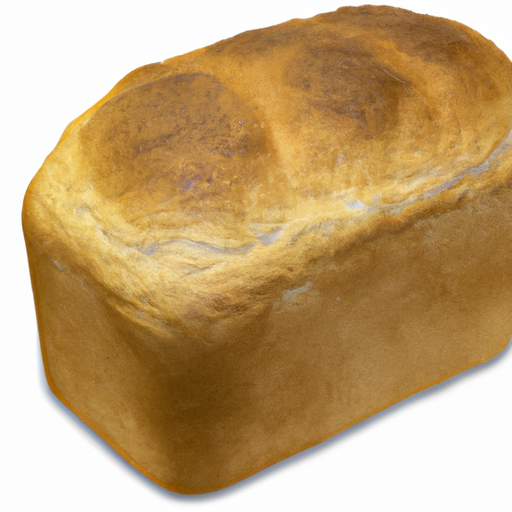

In [22]:
url = most_similar_image_urls[0]
response = requests.get(url)
img = Image.open(BytesIO(response.content))
display(img)


# retrieve data

In [33]:
matching_rows = df[df['final_url'].isin(most_similar_image_urls)]
mapped_data = matching_rows[['product_name', 'price', 'product_id']]
mapped_data['text'] = text
mapped_data['most_similar_image_urls'] = most_similar_image_urls

json_data = mapped_data.to_json(orient='records')

parsed_json = json.loads(json_data)
result = {"data": parsed_json}

final_json = json.dumps(result, indent=4)

C:\Users\shado\AppData\Local\Temp\ipykernel_4036\1309484271.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapped_data['input_text'] = text
C:\Users\shado\AppData\Local\Temp\ipykernel_4036\1309484271.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapped_data['most_similar_image_urls'] = most_similar_image_urls


In [34]:
print(final_json)

{
    "data": [
        {
            "product_name": "bread",
            "price": 2.49,
            "product_id": 7,
            "input_text": "bread",
            "most_similar_image_urls": "https://retailcontosoclothing.blob.core.windows.net/contoso-cg-shopping/bread.jpg"
        }
    ]
}
